<a href="https://colab.research.google.com/github/sydney-machine-learning/COVID19_sentinentanalysis/blob/main/EDA%20%2B%20Preprocessing%20%2B%20Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement paper code :

## **EDA**

In [1]:
#!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
import string
from textblob import TextBlob
from nltk.corpus import stopwords
#!pip install demoji
#nltk.download('all')
import demoji

In [3]:
#!pip install -q transformers

In [4]:
#!pip install torchtext

In [5]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
import torchtext
from torchtext import data

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [6]:
senwave = pd.read_csv("synthetic_sentiment_dataset.csv")
print("Length of Senwave Dataset = {}".format(len(senwave)))

Length of Senwave Dataset = 159312


In [7]:
senwave.head(10)

ID                                              Tweet  Optimistic  \
0  1.24E+18  Meditation and mindfulness tips for coping wit...         0.0   
1  1.24E+18  Contribute to INDIA FIGHTS CORONA @ Gandhinaga...         0.0   
2  1.24E+18  @DelhiPolice @DCPEastDelhi @msisodia @AamAadmi...         0.0   
3  1.24E+18  #SSC_UFM_MAT_KARONA\n#Corona is slow poison #U...         0.0   
4  1.24E+18  https://t.co/P7eQiq8tFa Mata Di \nDoston ise #...         0.0   
5  1.24E+18  @chintskap And my mum will be PhD in Corona vi...         0.0   
6  1.24E+18  @funnyhammy @GauravPandhi Dumbo, it's the amou...         1.0   
7  1.24E+18  . First they allowed Corona possessions. Now t...         0.0   
8  1.24E+18  @TV9Marathi \nKindly help us to break the chai...         1.0   
9  1.24E+18  When you are at safe at home, Corona is out bu...         0.0   

   Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  Denial  \
0       1.0         0.0          0.0      1.0  1.0      0.0     1.0   
1       0.0         0.0          0.0      1.0  1.0      1.0     1.0   
2       0.0         1.0          0.0      1.0  1.0      1.0     1.0   
3       0.0         1.0          0.0      1.0  0.0      1.0     1.0   
4       1.0         1.0          1.0      1.0  0.0      1.0     1.0   
5       0.0         1.0          1.0      0.0  0.0      1.0     1.0   
6       0.0         0.0          0.0      1.0  1.0      1.0     1.0   
7       0.0         1.0          1.0      1.0  1.0      1.0     0.0   
8       0.0         1.0          1.0      0.0  1.0      1.0     1.0   
9       1.0         0.0          1.0      0.0  1.0      1.0     1.0   

   Official report  Surprise  Joking  
0              0.0       0.0     1.0  
1              0.0       0.0     0.0  
2              0.0       0.0     0.0  
3              0.0       0.0     1.0  
4              0.0       1.0     1.0  
5              0.0       0.0     0.0  
6              0.0       0.0     1.0  
7              0.0       0.0     0.0  
8              0.0       0.0     1.0  
9              0.0       0.0     0.0

Text(0.5, 0, 'Count')

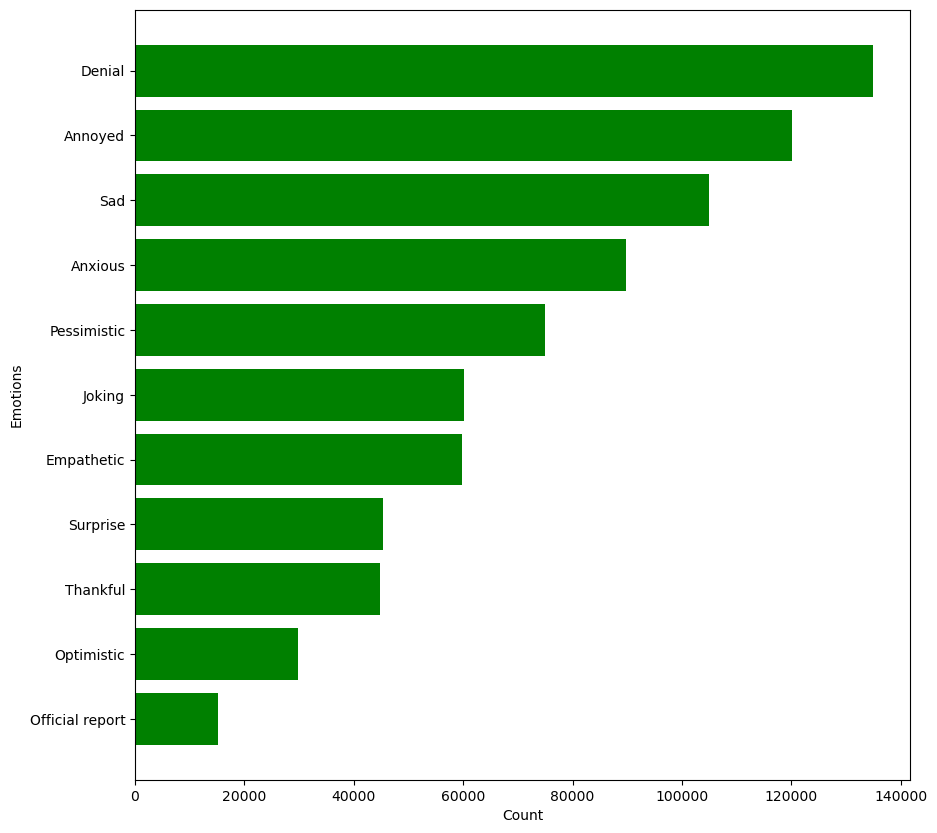

In [10]:
emotions = list(senwave.columns[2:])
#print(emotions)
#scores = [sum(senwave[x]) for x in emotions]
scores = senwave[emotions].sum()
pairs = []

for i in range(len(emotions)):
    pairs.append((emotions[i], scores[i]))

pairs = sorted(pairs, key = lambda x : x[1], reverse = False)
emotions_sorted = []
scores_sorted = []
#print(pairs)
for pair in pairs:
    emotions_sorted.append(pair[0])
    scores_sorted.append(pair[1])

fig = plt.figure(figsize = (10, 10))
plt.barh(emotions_sorted, scores_sorted, color = 'green')
plt.ylabel("Emotions")
plt.xlabel("Count")

In [11]:
rand_idx = np.random.randint(0, len(senwave))
print("Tweet : ", senwave.iloc[rand_idx]['Tweet'])
for e in emotions:
    print(e, ": ", senwave.iloc[rand_idx][e])

Tweet :  Birthday wishes to actress @DakkshiG 💐
She is making her debut with @RGVzoomin's #CoronaVirus film.… https://t.co/TmiIMnt6WD
Optimistic :  0.0
Thankful :  1.0
Empathetic :  1.0
Pessimistic :  1.0
Anxious :  0.0
Sad :  1.0
Annoyed :  1.0
Denial :  0.0
Official report :  0.0
Surprise :  0.0
Joking :  0.0


In [12]:
only_emotes = senwave[emotions]

In [13]:
only_emotes

Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0              0.0       1.0         0.0          0.0      1.0  1.0      0.0   
1              0.0       0.0         0.0          0.0      1.0  1.0      1.0   
2              0.0       0.0         1.0          0.0      1.0  1.0      1.0   
3              0.0       0.0         1.0          0.0      1.0  0.0      1.0   
4              0.0       1.0         1.0          1.0      1.0  0.0      1.0   
...            ...       ...         ...          ...      ...  ...      ...   
159307         NaN       NaN         NaN          NaN      NaN  NaN      NaN   
159308         NaN       NaN         NaN          NaN      NaN  NaN      NaN   
159309         NaN       NaN         NaN          NaN      NaN  NaN      NaN   
159310         NaN       NaN         NaN          NaN      NaN  NaN      NaN   
159311         NaN       NaN         NaN          NaN      NaN  NaN      NaN   

        Denial  Official report  Surprise  Joking  
0          1.0              0.0       0.0     1.0  
1          1.0              0.0       0.0     0.0  
2          1.0              0.0       0.0     0.0  
3          1.0              0.0       0.0     1.0  
4          1.0              0.0       1.0     1.0  
...        ...              ...       ...     ...  
159307     NaN              NaN       NaN     NaN  
159308     NaN              NaN       NaN     NaN  
159309     NaN              NaN       NaN     NaN  
159310     NaN              NaN       NaN     NaN  
159311     NaN              NaN       NaN     NaN  

[159312 rows x 11 columns]

In [14]:
only_emotes.iloc[0].tolist()

[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]

In [15]:
emote_array = np.zeros((11, 11))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7, 'Official report' : 8,
    'Surprise' : 9, 'Joking' : 10
}
for i in range(len(only_emotes)):
    l = only_emotes.iloc[i].tolist()
    for j in range(11):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 11):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

In [16]:
emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)
emote_df

Optimistic  Thankful  Empathetic  Pessimistic  Anxious     Sad  Annoyed  \
0        29805      8862       11911        14774    17929   20701    23834   
1         8862     44872       17880        22429    26822   31331    35939   
2        11911     17880       59781        29709    35698   41912    47904   
3        14774     22429       29709        74884    45037   52360    59828   
4        17929     26822       35698        45037    89771   62950    71789   
5        20701     31331       41912        52360    62950  105024    84197   
6        23834     35939       47904        59828    71789   84197   120048   
7        26868     40369       53863        67362    80696   94424   108012   
8         3037      4616        5972         7467     9065   10539    12091   
9         8938     13689       18051        22488    27117   31711    36344   
10       11983     17957       23991        30197    35990   41916    48097   

    Denial  Official report  Surprise  Joking  
0    26868             3037      8938   11983  
1    40369             4616     13689   17957  
2    53863             5972     18051   23991  
3    67362             7467     22488   30197  
4    80696             9065     27117   35990  
5    94424            10539     31711   41916  
6   108012            12091     36344   48097  
7   134961            13662     40863   54092  
8    13662            15119      4578    6095  
9    40863             4578     45372   18135  
10   54092             6095     18135   60091

<Axes: >

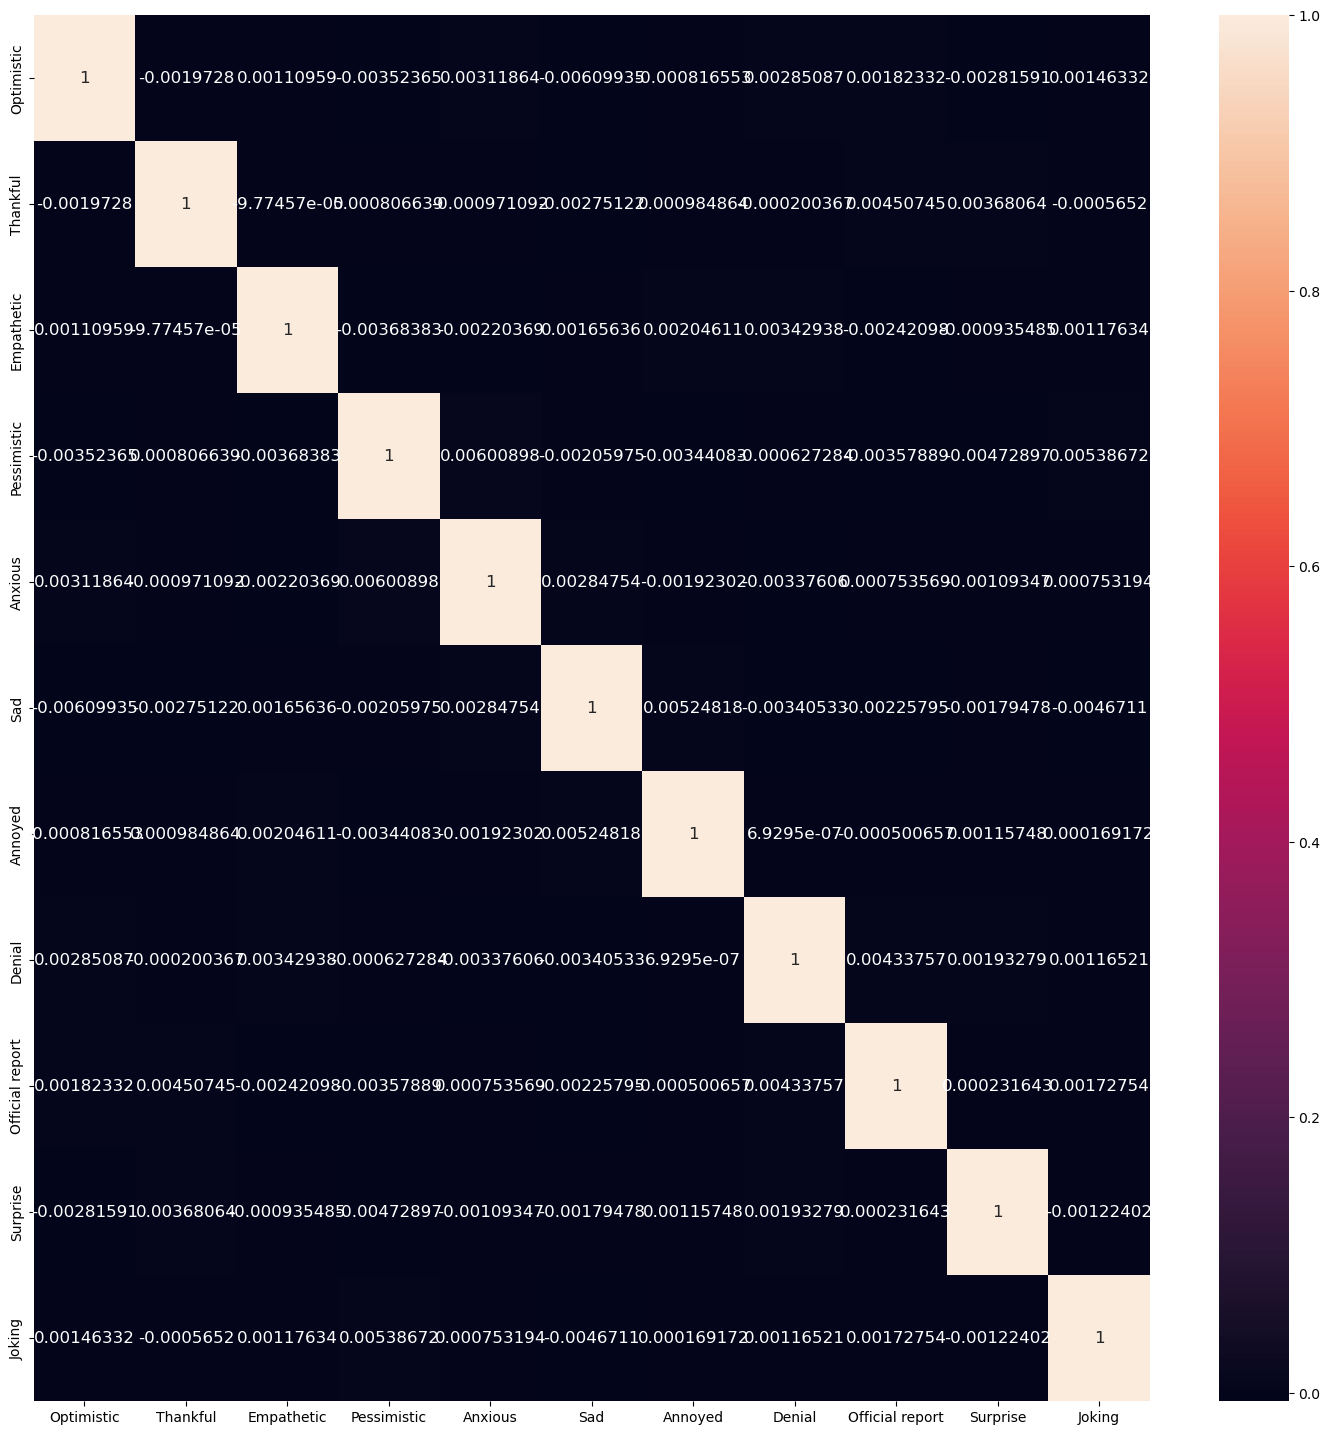

In [17]:
fig = plt.figure(figsize = (18, 18))
sns.heatmap(only_emotes.corr(), annot = True, xticklabels = emote_df.columns, yticklabels = emote_df.columns, fmt = 'g', annot_kws = {"size" : 12})

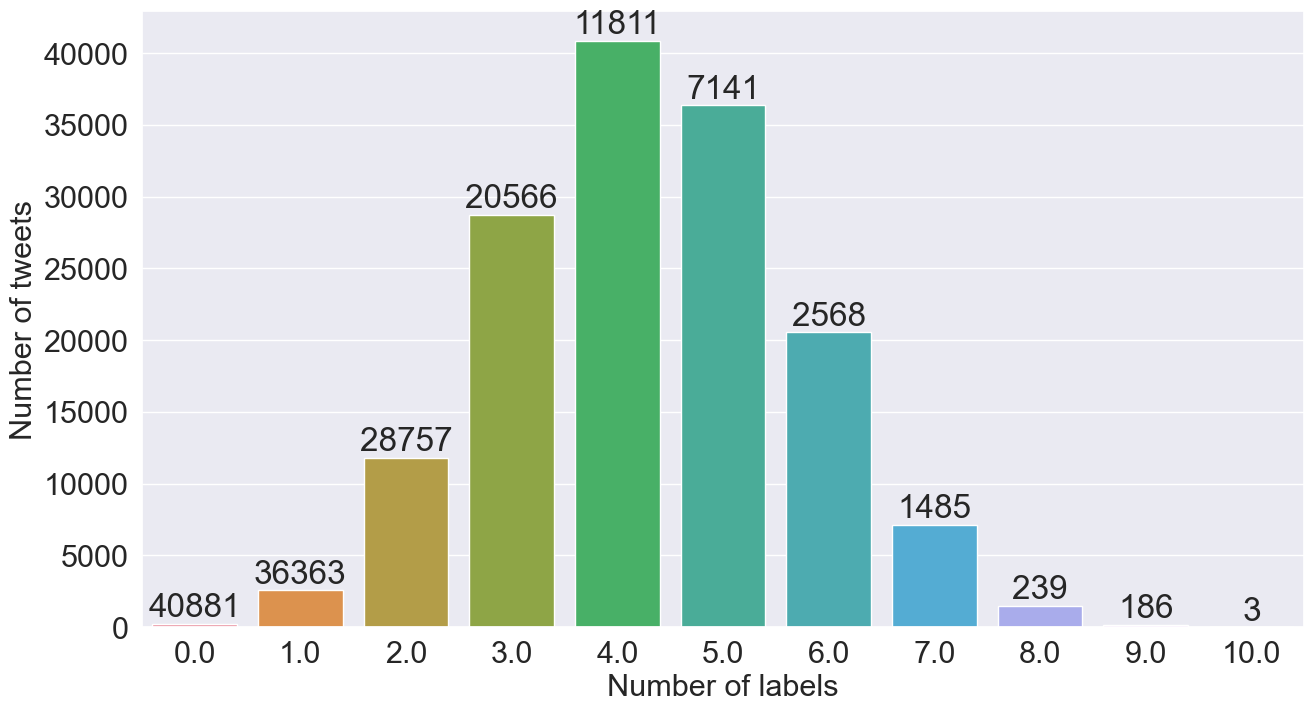

In [24]:
sns.set(font_scale=2)
plt.figure(figsize=(15, 8))

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values, orient='v')

plt.ylabel('Number of tweets', fontsize=22)
plt.xlabel('Number of labels', fontsize=22)

# Adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


In [25]:
multiLabel_counts

n_emotions
4.0     40881
5.0     36363
3.0     28757
6.0     20566
2.0     11811
7.0      7141
1.0      2568
8.0      1485
0.0       239
9.0       186
10.0        3
Name: count, dtype: int64

<Axes: >

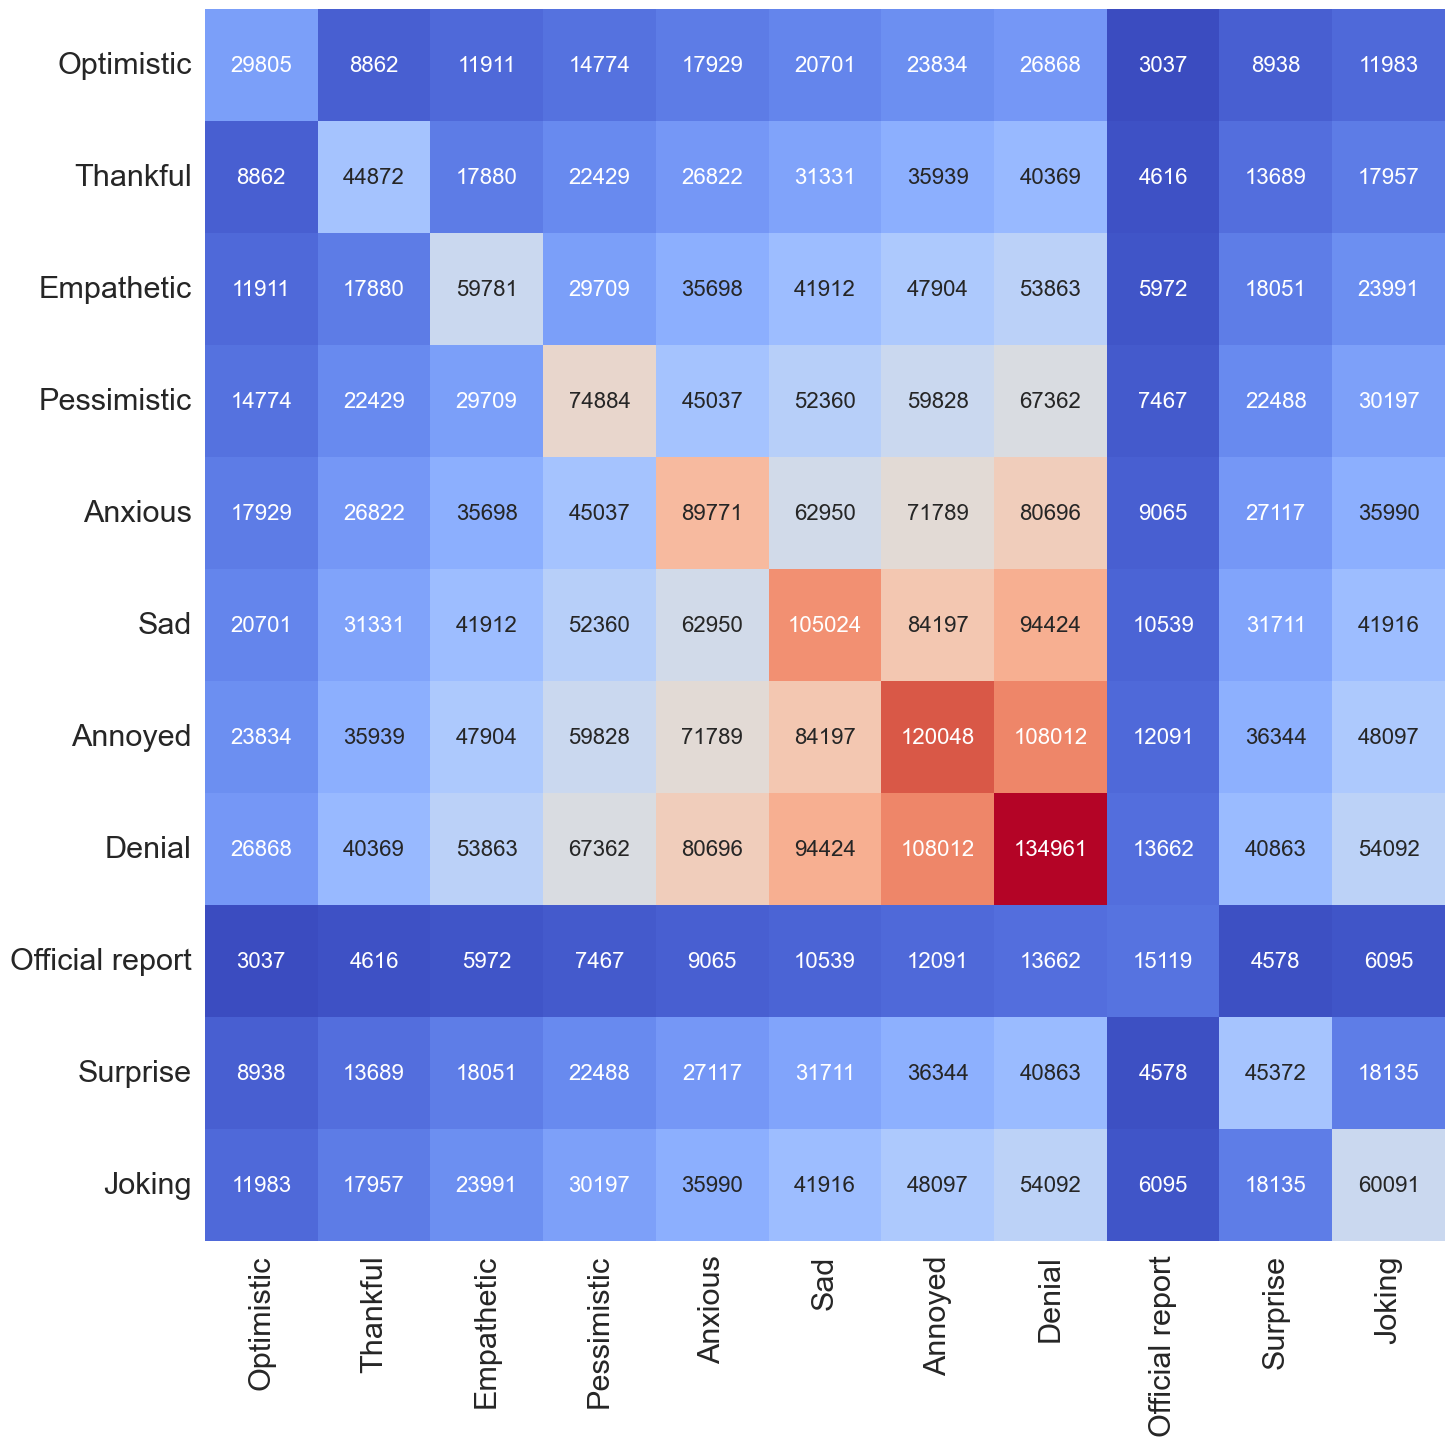

In [26]:
fig = plt.figure(figsize = (16,16))
sns.set(font_scale = 2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns, 
            fmt = 'g', annot_kws = {"size" : 16}, cbar = False, cbar_kws = {"shrink": .8})

Inferences:
*   We see that around 1000 people who were being optimistic also had a joke emotion attached to their tweet.
* Around 390 of the people who were being positive also had a surprise attached to their tweet. It could be probably because of some good news they weren't expecting.
* Pessimistic tweets usually were of joking nature or were displaying their annoyance.
*   When people were being thankful, it was usually towards the Government or God or People in general and therefore it made them optimistic for the future (about 240)
* About 1200 of the people who were annoyed were also joking. Displaying your annoyance through jokes never goes out of style.
* About 780 of the 2100 tweets which were sad were jokes, i.e. people were trying to drown their sadness through laughter.


**WORD CLOUDs**

**Optimism**

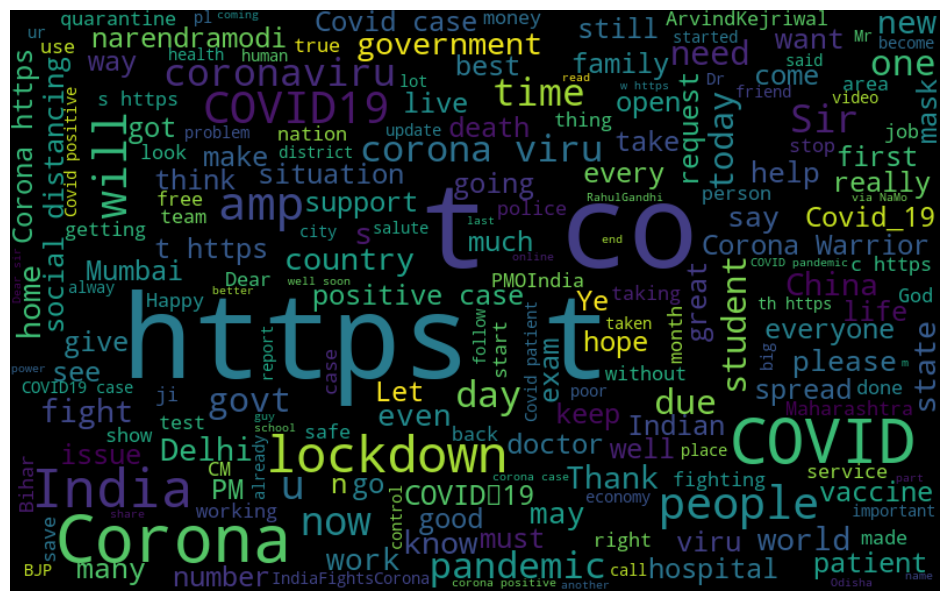

In [27]:
optimisticWords = " ".join([word for word in senwave['Tweet'][senwave['Optimistic'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(optimisticWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Thankful**

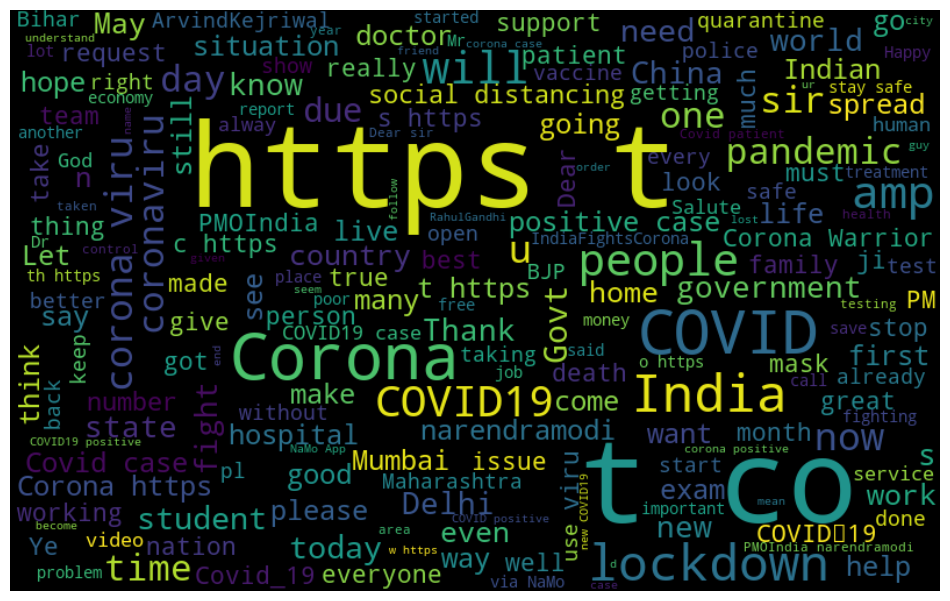

In [28]:
thankfulWords = " ".join([word for word in senwave['Tweet'][senwave['Thankful'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(thankfulWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Empathy**

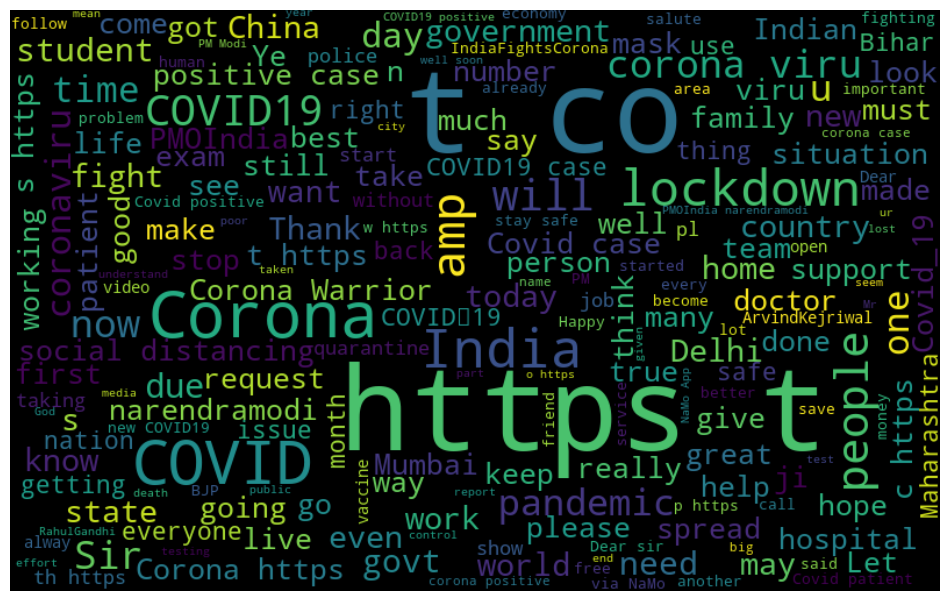

In [29]:
empatheticWords = " ".join([word for word in senwave['Tweet'][senwave['Empathetic'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(empatheticWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Anxiety**

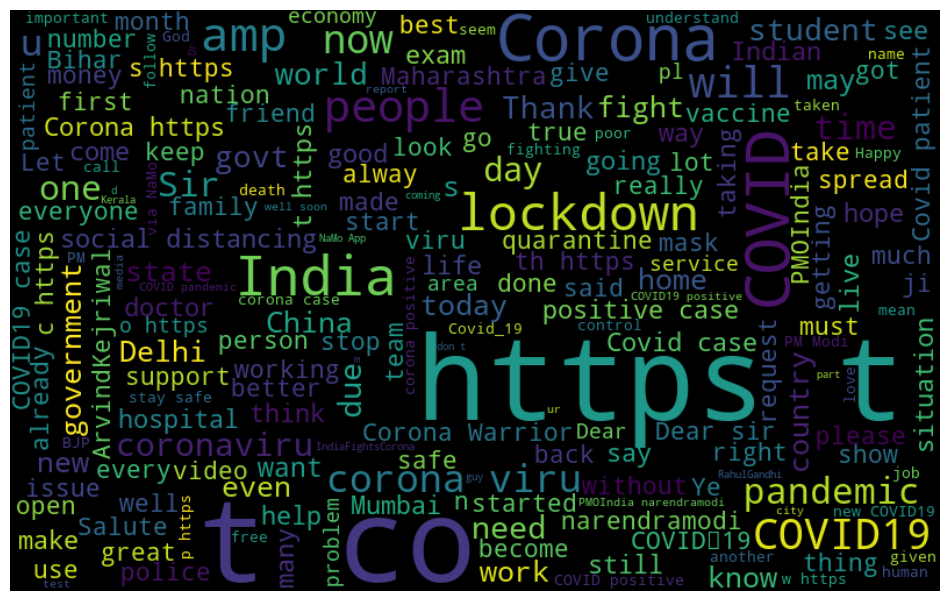

In [30]:
anxiousWords = " ".join([word for word in senwave['Tweet'][senwave['Anxious'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(anxiousWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Sad**

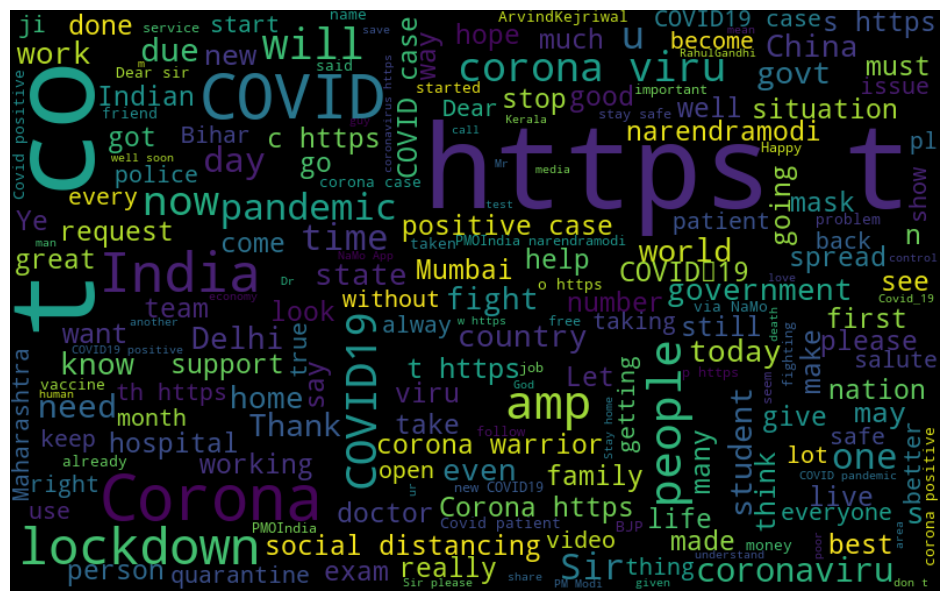

In [31]:
sadWords = " ".join([word for word in senwave['Tweet'][senwave['Sad'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(sadWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Official Report**

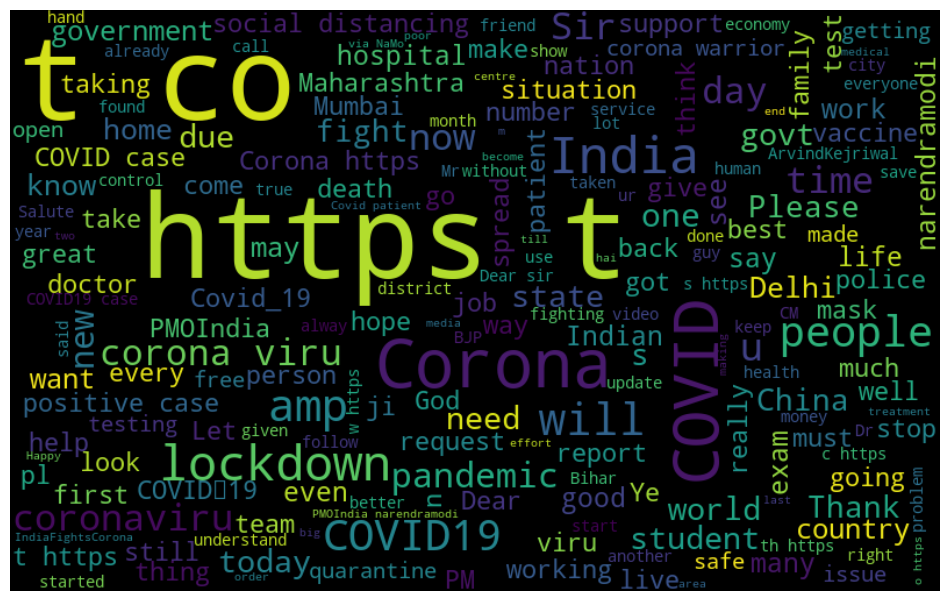

In [32]:
ORWords = " ".join([word for word in senwave['Tweet'][senwave['Official report'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(ORWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Joking**

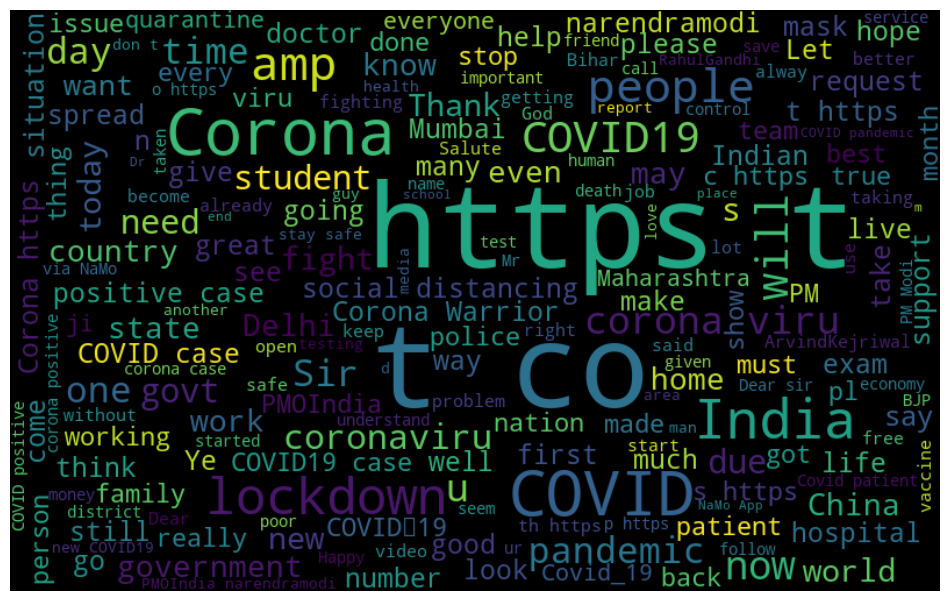

In [33]:
jokeWords = " ".join([word for word in senwave['Tweet'][senwave['Joking'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(jokeWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Cleaning followed by Unigram and Bigram analysis**

In [34]:
def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    StopWords = stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in StopWords]

In [35]:
words = clean(''.join(str(senwave['Tweet'].tolist())))

In [36]:
words[:20]

['meditation',
 'mindfulness',
 'tip',
 'coping',
 'corona',
 'virus',
 'pandemicas',
 'people',
 'become',
 'anxious',
 'sel',
 'httpstcozo65atakiv',
 'contribute',
 'india',
 'fight',
 'corona',
 'gandhinagar',
 'gujarat',
 'httpstcotmybkv8d0v',
 'delhipolice']

**N-gram analysis**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '(due, corona)'),
  Text(0, 1, '(corona, case)'),
  Text(0, 2, '(stay, home)'),
  Text(0, 3, '(corona, positive)'),
  Text(0, 4, '(covid, case)'),
  Text(0, 5, '(new, covid19)'),
  Text(0, 6, '(covid19, positive)'),
  Text(0, 7, '(corona, warrior)'),
  Text(0, 8, '(fight, corona)'),
  Text(0, 9, '(social, distancing)'),
  Text(0, 10, '(positive, case)'),
  Text(0, 11, '(covid19, case)'),
  Text(0, 12, '(covid, 19)'),
  Text(0, 13, '(corona, virus)'),
  Text(0, 14, '(nan, nan)')])

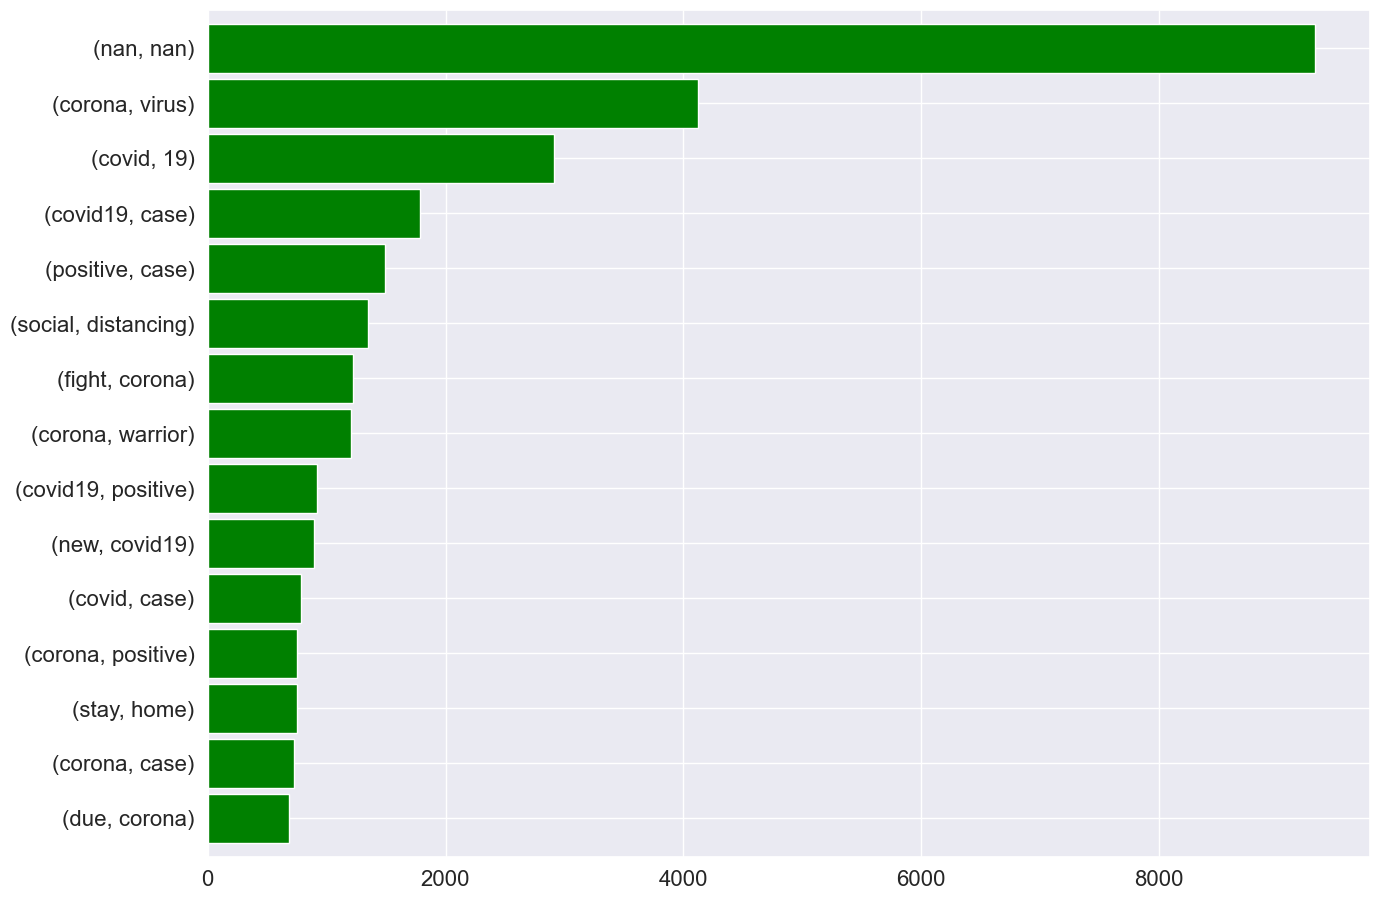

In [37]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:15]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:15]

bigrams_series.sort_values().plot.barh(color = 'green', width = 0.9, figsize = (15, 11))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '(help, doctor, got)'),
  Text(0, 1, '(got, infected, corona)'),
  Text(0, 2, '(due, covid, 19)'),
  Text(0, 3, '(positive, case, reported)'),
  Text(0, 4, '(home, stay, safe)'),
  Text(0, 5, '(total, number, case)'),
  Text(0, 6, '(stay, home, stay)'),
  Text(0, 7, '(tested, positive, covid19)'),
  Text(0, 8, '(fight, corona, virus)'),
  Text(0, 9, '(last, 24, hour)'),
  Text(0, 10, '(new, covid19, positive)'),
  Text(0, 11, '(new, covid19, case)'),
  Text(0, 12, '(covid19, positive, case)'),
  Text(0, 13, '(get, well, soon)'),
  Text(0, 14, '(nan, nan, nan)')])

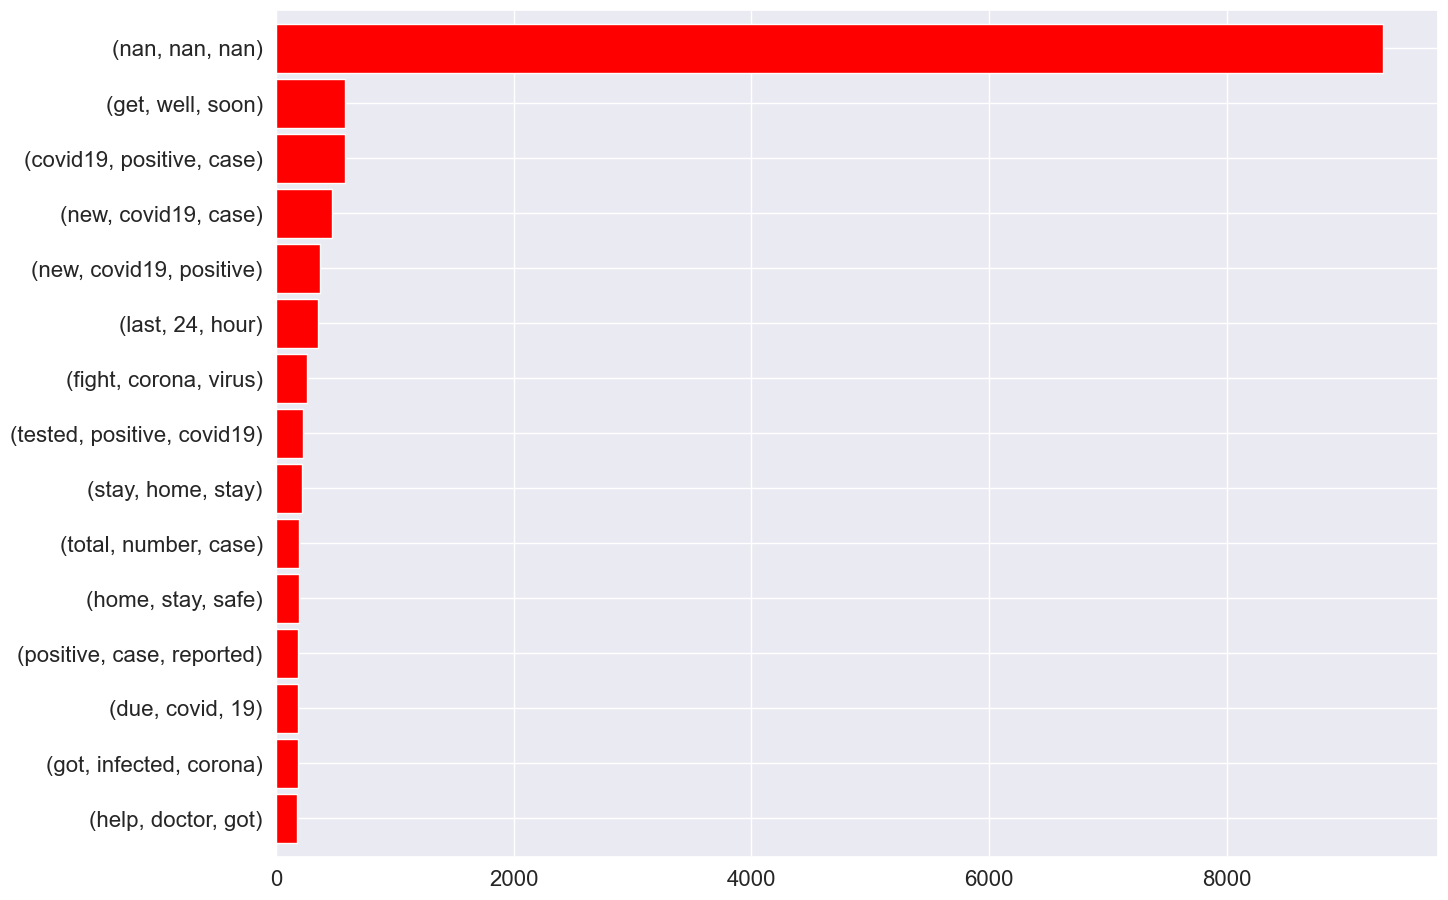

In [38]:
trigrams_series.sort_values().plot.barh(color = 'red', width = 0.9, figsize = (15, 11))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

# **Preprocessing**

In [39]:
contractions = { 
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
"hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
"i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
"mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she shall / she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
"so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
"they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
"y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"
}

In [40]:
contractionsWithAnotherInvertedComma = { 
"ain’t": "am not", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not",
"couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
"hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "he’s": "he is",
"how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
"i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would",
"it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us",
"ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
"mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have",
"shan’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will",
"she’ll’ve": "she will have", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
"so’ve": "so have", "so’s": "so is", "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",
"there’d’ve": "there would have", "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will",
"they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would",
"we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have",
"who’s": "who is", "who’ve": "who have", "why’s": "why is", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
"would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have",
"y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
"you’re": "you are", "you’ve": "you have"
}

In [49]:
import string
import nltk
import csv
import re
import demoji
from nltk.stem.wordnet import WordNetLemmatizer

class preprocess():
    def __init__(self, df, contractions, otherContractions):
        self.df = df
        self.contractions = contractions
        self.otherContractions = otherContractions
    
    def lower(self, tweet):
        return tweet.lower()
        
    def abbreviate(self, tweet):
        tweet = tweet.split(' ')
        j = 0
        for str_ in tweet:
            fileName = 'Abbreviations.txt'
            accessMode = 'r'
            with open(fileName, accessMode) as csvfile:
                dataFromFile = csv.reader(csvfile, delimiter = '=')
                str_ = re.sub('[^a-zA-Z0-9-_.]', '', str_)
                for row in dataFromFile:
                    if str_.upper() == row[0]:
                        tweet[j] = row[1]
                csvfile.close()
            j += 1
        return ' '.join(tweet)
    
    def expand(self, tweet):
        for word in tweet.split():
            if word in self.contractions.keys():
                tweet = tweet.replace(word, self.contractions[word])
            elif word in self.otherContractions.keys():
                tweet = tweet.replace(word, self.otherContractions[word])
        return tweet
    
    def emoji2text(self, tweet):
        emojis = demoji.findall(tweet)
        new_tweet = []
        for word in tweet.split():
            if word in emojis.keys():
                tweet = tweet.replace(word, emojis[word])
                new_tweet.append(emojis[word])
            wordmojis = demoji.findall(word)
            for char in word:
                if char in wordmojis.keys():
                    tweet = tweet.replace(word, wordmojis[char])
        
        return tweet

    def remove_hashtags(self, tweet):
        return re.sub(r'\#w+', '', tweet)
    
    def remove_mentions(self, tweet):
        for word in tweet.split():
            if word[0] == '@':
                tweet = tweet.replace(word, '')
        return tweet

    def remove_punctuations(self, tweet):
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        return tweet.translate(trantab)
    
    def preprocess_tweet(self, tweet):
        if isinstance(tweet, str):
            tweet = self.lower(tweet)
            tweet = self.abbreviate(tweet)
            tweet = self.expand(tweet)
            tweet = self.emoji2text(tweet)
            tweet = self.remove_mentions(tweet)
            tweet = self.remove_hashtags(tweet)
            tweet = self.remove_punctuations(tweet)
            return tweet
        else:
            return tweet


In [50]:
pp_class = preprocess(senwave, contractions, contractionsWithAnotherInvertedComma)
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : pp_class.preprocess_tweet(x))

In [51]:
senwave['Tweet'] = senwave['Tweet'].str.lower()
senwave.head(10)

ID                                              Tweet  Optimistic  \
0  1.24E+18  meditation and mindfulness tips for coping wit...         0.0   
1  1.24E+18  contribute to india fights corona  gandhinagar...         0.0   
2  1.24E+18       sir  please send a team immediately to sa...         0.0   
3  1.24E+18   ssc ufm mat karona\n corona is slow poison  u...         0.0   
4  1.24E+18  https   t co p7eqiq8tfa mata di \ndoston ise  ...         0.0   
5  1.24E+18   and my mum will be phd in corona virus from w...         0.0   
6  1.24E+18    dumbo  it is the amount that counts today in...         1.0   
7  1.24E+18    first they allowed corona possessions  now t...         0.0   
8  1.24E+18   \nkindly help us to break the chain of corona...         1.0   
9  1.24E+18  when you are at safe at home  corona is out bu...         0.0   

   Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  Denial  \
0       1.0         0.0          0.0      1.0  1.0      0.0     1.0   
1       0.0         0.0          0.0      1.0  1.0      1.0     1.0   
2       0.0         1.0          0.0      1.0  1.0      1.0     1.0   
3       0.0         1.0          0.0      1.0  0.0      1.0     1.0   
4       1.0         1.0          1.0      1.0  0.0      1.0     1.0   
5       0.0         1.0          1.0      0.0  0.0      1.0     1.0   
6       0.0         0.0          0.0      1.0  1.0      1.0     1.0   
7       0.0         1.0          1.0      1.0  1.0      1.0     0.0   
8       0.0         1.0          1.0      0.0  1.0      1.0     1.0   
9       1.0         0.0          1.0      0.0  1.0      1.0     1.0   

   Official report  Surprise  Joking  n_emotions  
0              0.0       0.0     1.0         4.0  
1              0.0       0.0     0.0         3.0  
2              0.0       0.0     0.0         4.0  
3              0.0       0.0     1.0         4.0  
4              0.0       1.0     1.0         7.0  
5              0.0       0.0     0.0         3.0  
6              0.0       0.0     1.0         5.0  
7              0.0       0.0     0.0         5.0  
8              0.0       0.0     1.0         6.0  
9              0.0       0.0     0.0         4.0

In [52]:
def check_coverage(vocab, embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:
            oov[word] = vocab[word]
            i += vocab[word]
            pass
        
    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key = operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose = True):
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except:
                vocab[word] = 1
    return vocab

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path, encoding = "utf-8") as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [53]:
GLOVE_EMBEDDING_FILE = '/content/drive/MyDrive/Covid 19 India/glove.840B.300d.txt'
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_FILE)
print(f'loaded {len(glove_embeddings)} word vectors ')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Covid 19 India/glove.840B.300d.txt'

In [ ]:
vocab = build_vocab(list(senwave['Tweet'].apply(lambda x : x.split())))
oov = check_coverage(vocab, glove_embeddings)
oov[:10]

In [ ]:
from COVID19_sentinentanalysissocialmedia.preprocessing import wordReplace
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : wordReplace.bruteGen(x))

# **Building the model followed by training & testing**

In [54]:
from sklearn.model_selection import train_test_split
sen_train, sen_test = train_test_split(senwave, train_size = 0.9, random_state = 1024)

sen_train.to_csv("train.csv", index = False)
sen_test.to_csv("test.csv", index = False)

In [55]:
sen_train.head(1)

ID                                              Tweet  \
46539  1.26E+18  3 to 5 mins away from his house  on the way ba...   

       Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
46539         1.0       1.0         0.0          1.0      1.0  1.0      1.0   

       Denial  Official report  Surprise  Joking  n_emotions  
46539     1.0              0.0       0.0     0.0         6.0

In [57]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for spacy from https://files.pythonhosted.org/packages/34/1a/cd4f39dcd28628bf69d2a6642aea3854f2de877196c737bf08e4ef3ca372/spacy-3.6.1-cp310-cp310-win_amd64.whl.metadata
     ---------------------------------------- 0.0/94.7 kB ? eta -:--:--
     ---------------------------------------- 94.7/94.7 kB 1.8 MB/s eta 0:00:00
  Obtaining dependency information for thinc<8.2.0,>=8.1.8 from https://files.pythonhosted.org/packages/c0/a9/6b250ddb2dd4006051332bca3ff1c60562e643a39f6f9b0f71a9806602e1/thinc-8.1.12-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for wasabi<1.2.0,>=0.9.1 from https://files.pythonhosted.org/packages/8f/69/26cbf0bad11703241cb84d5324d868097f7a8faf2f1888354dac8883f3fc/wasabi-1.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for srsly<3.0.0,>=2.4.3 from https://files.pythonhosted.org/packages/8d/e3/60769ee9b07a41aa9def88a78d

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.7.1 which is incompatible.


In [59]:
pip install --upgrade spacy pydantic

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [62]:
!pip install spacy==3.0.6
!pip install pydantic==1.8.2
!pip install typing-extensions==3.10.0.2

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
      --------------------------------------- 0.1/7.1 MB 4.3 MB/s eta 0:00:02
     --- ------------------------------------ 0.6/7.1 MB 7.5 MB/s eta 0:00:01
     ------- -------------------------------- 1.3/7.1 MB 10.3 MB/s eta 0:00:01
     --------- ------------------------------ 1.8/7.1 MB 11.2 MB/s eta 0:00:01
     ------------- -------------------------- 2.4/7.1 MB 11.1 MB/s eta 0:00:01
     ----------------- ---------------------- 3.1/7.1 MB 11.8 MB/s eta 0:00:01
     -------------------- ------------------- 3.7/7.1 MB 12.4 MB/s eta 0:00:01
     ------------------------- -------------- 4.5/7.1 MB 12.6 MB/s eta 0:00:01
     ----------------------------- ---------- 5.3/7.1 MB 13.0 MB/s eta 0:00:01
     --------------------------------- ------ 6.0/7.1 MB 13.2 MB/s eta 0:00:01
     ------------------------------------- -- 6.7/7.1 MB 13.3 M

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [164 lines of output]
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
      int length
  
  
  cdef class Vocab:
      cdef Pool mem
      cpdef readonly StringStore strings
            ^
  ------------------------------------------------------------
  
  spacy\vocab.pxd:28:10: Variables cannot be declared with 'cpdef'. Use 'cdef' instead.
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
  
  
  cdef class Vocab:
      cdef Pool mem
      cpdef readonly StringStore strings
      cpdef public Morphology morphology
            ^
  ------------------------------------------------------------
  
  spacy\vocab.pxd:29:10: Variables cannot be declared with 'cpdef'. Use 'cdef' instead.
  
  Error compiling Cython file:
  -------------------------------------------

Defaulting to user installation because normal site-packages is not writeable
  Using cached pydantic-1.8.2-py3-none-any.whl (126 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.2.1
    Uninstalling pydantic-2.2.1:
      Successfully uninstalled pydantic-2.2.1
Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic-core 2.6.1 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 3.10.0.2 which is incompatible.
astroid 2.14.2 requires typing-extensions>=4.0.0; python_version < "3.11", but you have typing-extensions 3.10.0.2 which is incompatible.


In [63]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

TWEET = torchtext.legacy.data.Field(sequential = True, lower = True, tokenize = tokenizer)
LABEL = torchtext.legacy.data.Field(sequential = False, use_vocab = False)

dataFields = [("ID", None), ("Tweet", TWEET), ("Optimistic", LABEL), ("Thankful", LABEL),
              ("Empathetic", LABEL), ("Pessimistic", LABEL), ("Anxious", LABEL), ("Sad", LABEL),
              ("Annoyed", LABEL), ("Denial", LABEL), ("Official report", LABEL),
              ("Surprise", LABEL), ("Joking", LABEL)]

train_dataset, test_dataset = torchtext.legacy.data.TabularDataset.splits(
    path = '/content/', train = 'train.csv', test = 'test.csv', format = 'csv', fields = dataFields, skip_header = True
    )

OSError: [E941] Can't find model 'en'. It looks like you're trying to load a model from a shortcut, which is obsolete as of spaCy v3.0. To load the model, use its full name instead:

nlp = spacy.load("en_core_web_sm")

For more details on the available models, see the models directory: https://spacy.io/models and if you want to create a blank model, use spacy.blank: nlp = spacy.blank("en")

In [92]:
!python -m spacy download en_core_web_sm
import spacy
spacy_en = spacy.load('en_core_web_sm')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

TWEET = torchtext.legacy.data.Field(sequential = True, lower = True, tokenize = tokenizer)
LABEL = torchtext.legacy.data.Field(sequential = False, use_vocab = False)

dataFields = [("ID", None), ("Tweet", TWEET), ("Optimistic", LABEL), ("Thankful", LABEL),
              ("Empathetic", LABEL), ("Pessimistic", LABEL), ("Anxious", LABEL), ("Sad", LABEL),
              ("Annoyed", LABEL), ("Denial", LABEL), ("Official report", LABEL),
              ("Surprise", LABEL), ("Joking", LABEL)]

train_dataset, test_dataset = torchtext.legacy.data.TabularDataset.splits(
    path = 'C:\\Users\\abhij\\OneDrive\\Documents', train = 'train.csv', test = 'test.csv', format = 'csv', fields = dataFields, skip_header = True
    )

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.4/12.8 MB 8.1 MB/s eta 0:00:02
     -- ------------------------------------- 0.8/12.8 MB 9.7 MB/s eta 0:00:02
     ---- ----------------------------------- 1.5/12.8 MB 10.2 MB/s eta 0:00:02
     ------ --------------------------------- 2.2/12.8 MB 11.7 MB/s eta 0:00:01
     --------- ------------------------------ 2.9/12.8 MB 12.3 MB/s eta 0:00:01
     ---------- ----------------------------- 3.5/12.8 MB 12.9 MB/s eta 0:00:01
     ----------- ---------------------------- 3.8/12.8 MB 12.2 MB/s eta 0:00:01
     ------------- -------------------------- 4.4/12.8 MB 11.6 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 11.9 MB/s eta 0:00:01
     ----------------- ---------------------- 5.7/12.8 MB 12.1 MB/s eta 0:00:01
     ------------------- -------------------- 6.3/12

AttributeError: module 'torchtext' has no attribute 'legacy'

In [95]:
import spacy
import re
import csv
import pandas as pd

# Download and load the SpaCy English tokenizer
spacy.cli.download("en_core_web_sm")
spacy_en = spacy.load('en_core_web_sm')

# Custom tokenizer function using SpaCy
def tokenizer(tweet):
    if isinstance(tweet, str):  # Check if tweet is a valid string
        tweet = re.sub(r'[\n]', ' ', tweet)
        return [tok.text for tok in spacy_en.tokenizer(tweet)]
    else:
        return []

# Define file paths
train_file = 'train.csv'
test_file = 'test.csv'

# Load CSV data using pandas
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Apply the tokenizer function to the 'Tweet' column
train_data['Tweet'] = train_data['Tweet'].apply(tokenizer)
test_data['Tweet'] = test_data['Tweet'].apply(tokenizer)

# Drop rows with empty 'Tweet' columns
train_data = train_data[train_data['Tweet'].apply(len) > 0]
test_data = test_data[test_data['Tweet'].apply(len) > 0]

# Extract labels from the DataFrame
label_columns = ["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious",
                 "Sad", "Annoyed", "Denial", "Official report", "Surprise", "Joking"]
train_labels = train_data[label_columns].values
test_labels = test_data[label_columns].values

# Convert the 'Tweet' column to a list
train_tweets = train_data['Tweet'].tolist()
test_tweets = test_data['Tweet'].tolist()


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [97]:
print("Number of training samples : {}\n Number of testing samples : {}".format(len(train_data), len(test_data)))

Number of training samples : 134986
 Number of testing samples : 15013


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
TWEET.build_vocab(train_dataset, vectors = 'glove.840B.300d')

#**Using BERT**

In [98]:
df = senwave.drop(['ID'], axis = 1)
df['list'] = df[df.columns[1:12]].values.tolist()
new_df = df[['Tweet', 'list']].copy()
new_df.head()

Tweet  \
0  meditation and mindfulness tips for coping wit...   
1  contribute to india fights corona  gandhinagar...   
2       sir  please send a team immediately to sa...   
3   ssc ufm mat karona\n corona is slow poison  u...   
4  https   t co p7eqiq8tfa mata di \ndoston ise  ...   

                                                list  
0  [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...  
2  [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...  
3  [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...  
4  [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...

**Preparing the dataset**

In [99]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [100]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'targets' : torch.tensor(self.targets[index], dtype = torch.float)
        }

In [101]:
train_dataset = sen_train.drop(['ID'], axis = 1)
train_dataset['list'] = train_dataset[train_dataset.columns[1:12]].values.tolist()
train_df = train_dataset[['Tweet', 'list']].copy()
train_df = train_df.reset_index(drop = True)

test_dataset = sen_test.drop(['ID'], axis = 1)
test_dataset['list'] = test_dataset[test_dataset.columns[1:12]].values.tolist()
test_df = test_dataset[['Tweet', 'list']].copy()
test_df = test_df.reset_index(drop = True)

In [102]:
training_set = CustomDataset(train_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

In [103]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

**Creating the Transformer model**

In [104]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [105]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

**Fine Tuning**

In [106]:
def train(epoch):
    model.train()
    total_loss = 0

    for unw, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids, return_dict = False)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()

        if unw % 2000 == 0:
            print(f'Iter : {unw+1}, Epoch: {epoch+1}, Loss: {total_loss/(unw+1)}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [107]:
EPOCHS = 4
for epoch in range(EPOCHS):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Iter : 1, Epoch: 1, Loss: 0.7463797926902771


KeyboardInterrupt: 

**Validating the data**

In [108]:
def valid():
    model.eval()
    req_targets = []
    req_outputs = []
    valid_loss = 0

    with torch.no_grad():
        for unw, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            valid_loss += loss.item()

            req_targets.extend(targets.cpu().detach().numpy().tolist())
            req_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    valid_loss /= len(testing_loader)
    return req_outputs, req_targets, valid_loss

In [ ]:
from sklearn import metrics

outputs, targets, valid_loss = valid()

In [ ]:
outputs = np.array(outputs)
targets = np.array(targets)

In [ ]:
int_outputs = np.zeros((outputs.shape[0], outputs.shape[1]))

for row in range(outputs.shape[0]):
    for col in range(outputs.shape[1]):
        if outputs[row][col] >= 0.5: int_outputs[row][col] = 1

In [ ]:
targets[0], int_outputs[0], outputs[0]

In [ ]:
bert_ham_loss = hamming_loss(targets, int_outputs)
bert_jacc_score = jaccard_score(targets, int_outputs, average = 'samples')
bert_lrap = label_ranking_average_precision_score(targets, outputs)
bert_f1_macro = f1_score(targets, int_outputs, average = 'macro')
bert_f1_micro = f1_score(targets, int_outputs, average = 'micro')

In [ ]:
print("Test Loss:", valid_loss)
print("Hamming Loss:", bert_ham_loss)
print("Jaccard Score:", bert_jacc_score)
print("Label Ranking Average Precision Score:", bert_lrap)
print("F1 Macro Score:", bert_f1_macro)
print("F1 Micro Score:", bert_f1_micro)

Results:


1.   lr = 1e-03: bce loss: 0.432, hamming loss: 0.183, jacc score: 0, lrap: 0.5659, f1 macro: 0, f1 micro: 0
2.   lr = 1e-04: bce loss: 0.432, hamming loss: 0.183, jacc score: 0, lrap: 0.5275, f1 macro: 0, f1 micro: 0
3.   lr = 1e-05: bce loss: 0.372, hamming loss: 0.142, jacc score: 0.5096, lrap: 0.766, f1 macro: 0.53, f1 micro: 0.587 



In [ ]:
torch.save(model, f = '/content/COVID19_sentinentanalysissocialmedia/models/bertmodel.pth')

# **Using LSTM**

**Hyperparameters to be considered**
*  Learning Rate
*  Hidden Dimension of LSTM
*  Dropout Probability
*  Threshold



In [ ]:
vocab = TWEET.vocab
BATCH_SIZE = 32
n_label = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iter, test_iter = data.BucketIterator.splits(datasets = (train_dataset, test_dataset),
                                                   batch_size = BATCH_SIZE,
                                                   sort_key = lambda x : len(x.Tweet),
                                                   sort_within_batch = False,
                                                   repeat = False,
                                                   device = device)

In [ ]:
np.random.seed(1024)
for i in range(TWEET.vocab.vectors.shape[0]):
    vec = TWEET.vocab.vectors[i]
    if torch.sum(vec).item() == 0:
        a = np.random.uniform(-0.25, 0.25, 300)
        TWEET.vocab.vectors[i] = torch.from_numpy(a)

In [ ]:
batch = next(train_iter.__iter__()); batch

In [ ]:
#idea taken from http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
class BatchWrapper():
    def __init__(self, dl, x_var, y_vars):
        self.dl = dl
        self.x_var = x_var
        self.y_vars = y_vars

    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var)
            if self.y_vars is not None:
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim = 1).float()
            else:
                y = torch.zeros((1))
            yield(x, y)
    
    def __len__(self):
        return len(self.dl)

In [ ]:
train_dl = BatchWrapper(train_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                              'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])
test_dl = BatchWrapper(test_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                            'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])

In [ ]:
class CustomLSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim, output_dim, drop_prob, bidirectional = False, use_glove = True):
        super().__init__()
        self.embeddings = nn.Embedding(len(vocab), embedding_dim)
        if use_glove:
            self.embeddings.weight.data.copy_(vocab.vectors)
            self.embeddings.weight.requires_grad = False
        self.drop_prob = drop_prob

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = bidirectional, batch_first = True, num_layers = 2)
        if bidirectional is True:
            self.lin = nn.Linear(2*hidden_dim, 64)
        else:
            self.lin = nn.Linear(hidden_dim, 64)
        self.fc = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(p = drop_prob)
    
    def forward(self, sentence):
        #sentence = [max_len, batch_size]

        embed = self.embeddings(torch.transpose(sentence, 0, 1))
        #embed = [batch_size, max_len, embedding_dim]
        
        if self.drop_prob:
            embed = self.dropout(embed)
        
        lstm_out, (hidden, cell) = self.lstm(embed)
        #lstm_out = [batch_size, max_len, 2*hidden_dim if bidirectional else hidden_dim]
        #hidden = [num_layers, batch_size, hidden_dim]
        #cell = [num_layers, batch_size, hidden_dim]
        
        out = lstm_out[:,-1,:].squeeze()
        #out = [batch_size, 2*hidden_dim if bidirectional else hidden_dim]
        
        out = self.lin(out)
        #out = [batch_size, 64]

        outputs = self.fc(out)
        #outputs = [batch_size, output_dim]
        
        return outputs

In [ ]:
def evaluation_metrics(actual_labels, pred_labels, threshold):
    int_pred_labels = pred_labels
    for i in range(len(pred_labels)):
        for j in range(11):
            if int_pred_labels[i][j] >= threshold: int_pred_labels[i][j] = 1
            else:
                int_pred_labels[i][j] = 0
    
    ham_loss = hamming_loss(actual_labels, int_pred_labels)
    jacc_score = jaccard_score(actual_labels, int_pred_labels, average = 'samples')
    lrap = label_ranking_average_precision_score(actual_labels, pred_labels)
    f1_macro = f1_score(actual_labels, int_pred_labels, average = 'macro')
    f1_micro = f1_score(actual_labels, int_pred_labels, average = 'micro')

    return ham_loss, jacc_score, lrap, f1_macro, f1_micro

In [ ]:
def train(model, loss_fn, optimizer, n_epochs, train_dl, threshold):

    train_losses = []  
    hamming_losses = []
    jaccard_scores = []
    lraps = []  
    iter = 1

    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        pred_labels = []
        actual_labels = []
        model.train()
        for x, y in train_dl:
            #print(x.shape, y.shape)
            optimizer.zero_grad()

            preds = model(x)

            m = nn.Sigmoid()
            sig_preds = m(preds)
            
            for tens in sig_preds:
                pred_labels.append(tens.cpu().detach().numpy())
            for tens in y:
                actual_labels.append(tens.cpu().detach().numpy())

            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.shape[0]

        ham_loss, jacc_score, lrap, f1_macro, f1_micro = evaluation_metrics(actual_labels, pred_labels, threshold)

        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)
        hamming_losses.append(ham_loss)
        lraps.append(lrap)
        jaccard_scores.append(jacc_score)
        '''
        if iter % 5 == 0:
            print("Epoch: ", epoch)
            print("Binary Cross Entropy With Logits Loss: {:.4f}".format(epoch_loss))
            print("Hamming Loss : {:.4f}".format(ham_loss))
            print("Jaccard Score: {:.4f}".format(jacc_score))
            print("Label Ranking Average Precision Score: {:.4f}".format(lrap))
            print("F1 Macro Score: {:.4f}".format(f1_macro))
            print("F1 Micro Score: {:.4f}".format(f1_micro))
            print("\n")
        iter += 1
        '''
    return train_losses, hamming_losses, jaccard_scores, lraps, f1_macro, f1_micro

In [ ]:
def test(model, loss_fn, test_dl, threshold):
    running_loss = 0.0
    pred_labels = []
    actual_labels = []
    model.eval()
    for x, y in test_dl:
        #print(x.shape, y.shape)

        preds = model(x)

        m = nn.Sigmoid()
        sig_preds = m(preds)
        
        for tens in sig_preds:
            pred_labels.append(tens.cpu().detach().numpy())
        for tens in y:
            actual_labels.append(tens.cpu().detach().numpy())

        loss = loss_fn(preds, y)

        running_loss += loss.item() * x.shape[0]

    ham_loss, jacc_score, lrap, f1_macro, f1_micro = evaluation_metrics(actual_labels, pred_labels, threshold)

    test_loss = running_loss / len(test_dataset)
    return test_loss, ham_loss, jacc_score, lrap, f1_macro, f1_micro

# **Experimentation with various combinations of the hyperparameters**

## Till 22-12-2020

In [ ]:
learning_rates = [1e-3]
hidden_dims = [128, 256]
thresholds = [0.4, 0.45, 0.5]
dropouts = [True, False]

all_models = []
iter = 1
#number of iterations = 3*2*2 = 12 = number of models

for learning_rate in learning_rates:
    for hidden_dim in hidden_dims:
        for threshold in thresholds:
            for dropout in dropouts:
                model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = dropout)
                model = model.to(device)

                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                loss_fn = nn.BCEWithLogitsLoss()

                train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
                all_models.append(model)
                print("Iteration : {}".format(iter))
                print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout = {}".format(learning_rate, hidden_dim, threshold, dropout))
                print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
                print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
                print("Jaccard Score: {:.4f}".format(max(jacc_score)))
                print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
                print("F1 Macro Score: {:.4f}".format(f1_macro))
                print("F1 Micro Score: {:.4f}".format(f1_micro))
                print("\n")

                test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
                print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
                print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
                print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
                print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
                print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
                print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
                print("\n")
                print("----------------------------------------------------------------")
                iter += 1

## 23-12-2020
*  taking inference from the previous days, having a dropout in the LSTM layer has always lowered the overfitting. Hence we will be using dropout layers in all models today.
*  We shall experiment with the values of the dropout probability today

In [ ]:
learning_rates = [1e-3]
hidden_dims = [128, 256]
thresholds = [0.4, 0.45, 0.5]
drop_probs = [0.4, 0.5, 0.6, 0.7]

all_models = []
iter = 1
#number of iterations = 4*3*2 = 24 = number of models

for learning_rate in learning_rates:
    for hidden_dim in hidden_dims:
        for threshold in thresholds:
            for drop_prob in drop_probs:
                model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
                model = model.to(device)

                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                loss_fn = nn.BCEWithLogitsLoss()

                train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
                all_models.append(model)
                print("Iteration : {}".format(iter))
                print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout Probability = {}".format(learning_rate, hidden_dim, threshold, drop_prob))
                print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
                print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
                print("Jaccard Score: {:.4f}".format(max(jacc_score)))
                print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
                print("F1 Macro Score: {:.4f}".format(f1_macro))
                print("F1 Micro Score: {:.4f}".format(f1_micro))
                print("\n")

                test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
                print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
                print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
                print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
                print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
                print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
                print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
                print("\n")
                print("----------------------------------------------------------------")
                iter += 1

# **Some inferences**
*  Best Test BCE with logits loss at Iteration 12<br>
*  Best Test Hamming Loss at Iteration 12<br>
*  Best Test Jaccard Score at Iteration 3 & 16<br>
*  Best Test LRAP Score at Iteration 11<br>
*  Best Test F1 Macro Score at Iteration 16<br>
*  Best Test F1 Micro Score at Iteration 3<br>
<br> <br>
*  This indicates that we need only consider hyperparams corresponding to iterations 3, 11, 12 and 16



 **Hyperparameters to be considered for the final steps**:

*   Learning Rate: 0.001
*   Hidden Dimension: 3, 11, 12 = 128 & 16 = 256
*   Threshold: 3 & 16 = 0.4, 11 & 12 = 0.5
*   Dropout Probability: 3 & 11 = 0.6, 12 & 16 = 0.7

Since we see that either the best hyperparameters correspond to dropout probability = 0.6 or 0.7, we use dropout probability = 0.65 which is verified below as performing nearly the same or better

## Final evaluation using narrowed down hyperparameters
26-12-2020

In [ ]:
%%time
learning_rate = 1e-3
hidden_dim = 128
threshold = 0.5
drop_prob = 0.65

all_bce_losses = []
all_hamm_losses = []
all_jacc_scores = []
all_lraps = []
all_f1_macro = []
all_f1_micro = []
all_models = []

for exp in range(1, 11):

    print("Experiment {}".format(exp), '\n\n')

    model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
    torch.save(model, 'model{}.pth'.format(exp))
    '''
    print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout Probability = {}".format(learning_rate, hidden_dim, threshold, drop_prob))
    print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
    print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
    print("Jaccard Score: {:.4f}".format(max(jacc_score)))
    print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
    print("F1 Macro Score: {:.4f}".format(f1_macro))
    print("F1 Micro Score: {:.4f}".format(f1_micro))
    print("\n")
    '''

    test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
    all_bce_losses.append(test_loss)
    all_hamm_losses.append(test_hamm_loss)
    all_jacc_scores.append(test_jacc_score)
    all_lraps.append(test_lrap)
    all_f1_macro.append(test_f1_macro)
    all_f1_micro.append(test_f1_micro)


    print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
    print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
    print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
    print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
    print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
    print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
    print("\n")

In [ ]:
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(all_bce_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(all_hamm_losses)/10))
print("Average Jaccard Score: {:.4f}".format(sum(all_jacc_scores)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(all_lraps)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(all_f1_macro)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(all_f1_micro)/10))

**Model 7 performed the best, so I downloaded the weights**

## Using a different value of dropout probability

In [ ]:
%%time
learning_rate = 1e-3
hidden_dim = 128
threshold = 0.5
drop_prob = 0.6

all_bce_losses = []
all_hamm_losses = []
all_jacc_scores = []
all_lraps = []
all_f1_macro = []
all_f1_micro = []
all_models = []

for exp in range(1, 11):

    print("Experiment {}".format(exp), '\n\n')

    model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
    torch.save(model, 'model{}.pth'.format(exp))
    '''
    print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout Probability = {}".format(learning_rate, hidden_dim, threshold, drop_prob))
    print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
    print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
    print("Jaccard Score: {:.4f}".format(max(jacc_score)))
    print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
    print("F1 Macro Score: {:.4f}".format(f1_macro))
    print("F1 Micro Score: {:.4f}".format(f1_micro))
    print("\n")
    '''

    test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
    all_bce_losses.append(test_loss)
    all_hamm_losses.append(test_hamm_loss)
    all_jacc_scores.append(test_jacc_score)
    all_lraps.append(test_lrap)
    all_f1_macro.append(test_f1_macro)
    all_f1_micro.append(test_f1_micro)


    print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
    print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
    print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
    print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
    print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
    print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
    print("\n")

In [ ]:
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(all_bce_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(all_hamm_losses)/10))
print("Average Jaccard Score: {:.4f}".format(sum(all_jacc_scores)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(all_lraps)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(all_f1_macro)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(all_f1_micro)/10))

## Comparison between having GloVe Vectors and not having GloVe Vectors 
28-12-2020

In [ ]:
%%time
learning_rate = 1e-3
hidden_dim = 128
threshold = 0.5
drop_prob = 0.65

all_glove_losses = []
all_glove_ham = []
all_glove_jacc = []
all_glove_lrap = []
all_glove_f1mac = []
all_glove_f1mic = []

all_nonglove_losses = []
all_nonglove_ham = []
all_nonglove_jacc = []
all_nonglove_lrap = []
all_nonglove_f1mac = []
all_nonglove_f1mic = []

glove = [True, False]
for exp in range(1, 11):
    for g in glove:
        model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob, use_glove = g)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_fn = nn.BCEWithLogitsLoss()

        train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
        test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
        print("Test Binary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
        print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
        print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
        print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
        print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
        print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
        print("\n")

        if g is True:
            all_glove_losses.append(test_loss)
            all_glove_ham.append(test_hamm_loss)
            all_glove_jacc.append(test_jacc_score)
            all_glove_lrap.append(test_lrap)
            all_glove_f1mac.append(test_f1_macro)
            all_glove_f1mic.append(test_f1_micro)
        else:
            all_nonglove_losses.append(test_loss)
            all_nonglove_ham.append(test_hamm_loss)
            all_nonglove_jacc.append(test_jacc_score)
            all_nonglove_lrap.append(test_lrap)
            all_nonglove_f1mac.append(test_f1_macro)
            all_nonglove_f1mic.append(test_f1_micro)

In [ ]:
print("Using glove vectors:")
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(all_glove_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(all_glove_ham)/10))
print("Average Jaccard Score: {:.4f}".format(sum(all_glove_jacc)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(all_glove_lrap)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(all_glove_f1mac)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(all_glove_f1mic)/10))
print("\n\n")

print("Not using glove vectors:")
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(all_nonglove_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(all_nonglove_ham)/10))
print("Average Jaccard Score: {:.4f}".format(sum(all_nonglove_jacc)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(all_nonglove_lrap)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(all_nonglove_f1mac)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(all_nonglove_f1mic)/10))

In [ ]:
print(np.std(np.array(all_glove_losses)), np.std(np.array(all_glove_ham)), np.std(np.array(all_glove_jacc)), np.std(np.array(all_glove_lrap)),
      np.std(np.array(all_glove_f1mac)), np.std(np.array(all_glove_f1mic)))

print(np.std(np.array(all_nonglove_losses)), np.std(np.array(all_nonglove_ham)), np.std(np.array(all_nonglove_jacc)), np.std(np.array(all_nonglove_lrap)),
      np.std(np.array(all_nonglove_f1mac)), np.std(np.array(all_nonglove_f1mic)))

Here we see that having pretrained word vectors helps

## Comparing a unidirectional and a bidirectional network
03-01-2021

update - 10-01-2021

In [ ]:
learning_rate = 1e-3
hidden_dim = 128
threshold = 0.5
drop_prob = 0.65

iter = 1
bce_losses = []
ham_losses = []
jacc_scores = []
lrap_scores = []
f1_macros = []
f1_micros = []

bi_bce_losses = []
bi_ham_losses = []
bi_jacc_scores = []
bi_lrap_scores = []
bi_f1_macros = []
bi_f1_micros = []

for exp in range(1, 11):
    for dirn in [True, False]:
        model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, 
                            drop_prob = drop_prob, bidirectional = dirn, use_glove = True)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_fn = nn.BCEWithLogitsLoss()

        train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
        test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
        
        if dirn is True:
            bi_bce_losses.append(test_loss)
            bi_ham_losses.append(test_hamm_loss)
            bi_jacc_scores.append(test_jacc_score)
            bi_lrap_scores.append(test_lrap)
            bi_f1_macros.append(test_f1_macro)
            bi_f1_micros.append(test_f1_micro)
        else:
            bce_losses.append(test_loss)
            ham_losses.append(test_hamm_loss)
            jacc_scores.append(test_jacc_score)
            lrap_scores.append(test_lrap)
            f1_macros.append(test_f1_macro)
            f1_micros.append(test_f1_micro)

        print("Iteration {} / {} done".format(iter, 20))
        iter += 1

In [ ]:
print("Using bidirectional lstm:")
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(bi_bce_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(bi_ham_losses)/10))
print("Average Jaccard Score: {:.4f}".format(sum(bi_jacc_scores)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(bi_lrap_scores)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(bi_f1_macros)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(bi_f1_micros)/10))
print("\n\n")

print("Using lstm:")
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(bce_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(ham_losses)/10))
print("Average Jaccard Score: {:.4f}".format(sum(jacc_scores)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(lrap_scores)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(f1_macros)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(f1_micros)/10))

In [ ]:
print("Using bidirectional lstm:")
print("Deviation of Binary Cross Entropy With Logits Loss: {:.4f}".format(np.std(np.array(bi_bce_losses))))
print("Deviation of Hamming Loss : {:.4f}".format(np.std(np.array(bi_ham_losses))))
print("Deviation of Jaccard Score: {:.4f}".format(np.std(np.array(bi_jacc_scores))))
print("Deviation of Label Ranking Average Precision Score: {:.4f}".format(np.std(np.array(bi_lrap_scores))))
print("Deviation of F1 Macro Score: {:.4f}".format(np.std(np.array(bi_f1_macros))))
print("Deviation of F1 Micro Score: {:.4f}".format(np.std(np.array(bi_f1_micros))))
print("\n\n")

print("Using lstm:")
print("Deviation of Binary Cross Entropy With Logits Loss: {:.4f}".format(np.std(np.array(bce_losses))))
print("Deviation of Hamming Loss : {:.4f}".format(np.std(np.array(ham_losses))))
print("Deviation of Jaccard Score: {:.4f}".format(np.std(np.array(jacc_scores))))
print("Deviation of Label Ranking Average Precision Score: {:.4f}".format(np.std(np.array(lrap_scores))))
print("Deviation of F1 Macro Score: {:.4f}".format(np.std(np.array(f1_macros))))
print("Deviation of F1 Micro Score: {:.4f}".format(np.std(np.array(f1_micros))))

we see that a bidirectional network performs much worse than a unidirectional network with the same set of parameters

## Comparing dropout values of 0, 0.5, 0.6, 0.7 for adding in the table
06-01-2021

update - 10-01-2021

In [ ]:
learning_rates = [1e-3]
hidden_dims = [128]
drop_probs = [0, 0.5, 0.6, 0.7]

for drop_prob in drop_probs:
    bce_losses = []
    ham_losses = []
    jacc_scores = []
    lrap_scores = []
    f1_macros = []
    f1_micros = []
    for exp in range(1, 11):
        model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_fn = nn.BCEWithLogitsLoss()

        train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
        #all_models.append(model)

        test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
        bce_losses.append(test_loss)
        ham_losses.append(test_hamm_loss)
        jacc_scores.append(test_jacc_score)
        lrap_scores.append(test_lrap)
        f1_macros.append(test_f1_macro)
        f1_micros.append(test_f1_micro)
    
    print("Dropout = {}".format(drop_prob))
    print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(bce_losses)/10))
    print("Average Hamming Loss : {:.4f}".format(sum(ham_losses)/10))
    print("Average Jaccard Score: {:.4f}".format(sum(jacc_scores)/10))
    print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(lrap_scores)/10))
    print("Average F1 Macro Score: {:.4f}".format(sum(f1_macros)/10))
    print("Average F1 Micro Score: {:.4f}".format(sum(f1_micros)/10))
    print("\n\n")

    print("Deviation of Binary Cross Entropy With Logits Loss: {:.4f}".format(np.std(np.array(bce_losses))))
    print("Deviation of Hamming Loss : {:.4f}".format(np.std(np.array(ham_losses))))
    print("Deviation of Jaccard Score: {:.4f}".format(np.std(np.array(jacc_scores))))
    print("Deviation of Label Ranking Average Precision Score: {:.4f}".format(np.std(np.array(lrap_scores))))
    print("Deviation of F1 Macro Score: {:.4f}".format(np.std(np.array(f1_macros))))
    print("Deviation of F1 Micro Score: {:.4f}".format(np.std(np.array(f1_micros))))
    print("\n\n")

In [ ]:
print("BCE Losses: ", bce_losses)
print("Hamming Losses: ", ham_losses)
print("Jaccard Scores: ", jacc_scores)
print("LRAP Scores: ", lrap_scores)
print("F1 Macros: ", f1_macros)
print("F1 Micros: ", f1_micros)

## Modeling on IEEE Dataset

In [ ]:
ieee = pd.read_csv("/content/drive/MyDrive/Covid 19 India/ieee_extract.csv")
ieee['tweet'] = ieee['tweet'].str.lower()
ieee.head(10)

In [ ]:
def emoji2text(tweet):
    emojis = demoji.findall(tweet)
    new_tweet = []
    for word in tweet.split():
        if word in emojis.keys():
            tweet = tweet.replace(word, emojis[word])
            new_tweet.append(emojis[word])
        wordmojis = demoji.findall(word)
        for char in word:
            if char in wordmojis.keys():
                tweet = tweet.replace(word, wordmojis[char])
    
    return tweet

def remove_hashtags(tweet):
    return re.sub(r'\#w+', '', tweet)

def remove_mentions(tweet):
    for word in tweet.split():
        if word[0] == '@':
            tweet = tweet.replace(word, '')
    return tweet

def remove_punctuations(tweet):
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')
    return tweet.translate(trantab)

def remove_url(text):
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags = re.MULTILINE)

def clean(tweet):
    tweet = emoji2text(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_mentions(tweet)
    #tweet = remove_punctuations(tweet)
    tweet = remove_url(tweet)
    return tweet

In [ ]:
ieee['tweet'] = ieee['tweet'].astype(str)
ieee['tweet'] = ieee['tweet'].astype(str)
ieee['tweet'] = ieee['tweet'].astype(str)
ieee['tweet'] = ieee['tweet'].apply(lambda x : clean(x))

In [ ]:
ieee

In [ ]:
ieee = ieee.dropna()
ieee = ieee.drop_duplicates(['tweet'])
ieee['tweet'] = ieee['tweet'].str.lower()
ieee['month'] = ieee['month'].str.lower()
ieee['place'] = ieee['place'].str.lower()
ieee['tweet'] = ieee['tweet'].apply(lambda x : re.sub('\n', '', x))

In [ ]:
ieee = ieee.reset_index()

# **Loading Bert**

In [ ]:
bert = torch.load("/content/drive/MyDrive/Covid 19 India/bertmodel.pth")
bert

In [ ]:
bert_df = pd.DataFrame()
bert_df['Tweet'] = ieee['tweet']
values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * 145556
bert_df['list'] = values

In [ ]:
test_dataset = CustomDataset(bert_df, tokenizer, MAX_LEN)

In [ ]:
bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }   

test_loader = DataLoader(test_dataset, **bert_test_params)

In [ ]:
def test():
    bert.eval()
    bert_outputs = []

    with torch.no_grad():
        for unw, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = bert(ids, mask, token_type_ids)

            bert_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return bert_outputs

In [ ]:
test_outputs = test()

In [ ]:
test_outputs = np.array(test_outputs)

for i in range(test_outputs.shape[0]):
    for j in range(test_outputs.shape[1]):
        if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
        else: test_outputs[i][j] = 0

In [ ]:
bert_df['Optimistic'] = "None"
bert_df['Thankful'] = "None"
bert_df['Empathetic'] = "None"
bert_df['Pessimistic'] = "None"
bert_df['Anxious'] = "None"
bert_df['Sad'] = "None"
bert_df['Annoyed'] = "None"
bert_df['Denial'] = "None"
bert_df['Official report'] = "None"
bert_df['Surprise'] = "None"
bert_df['Joking'] = "None"
bert_df = bert_df.drop(['list'], axis = 1)

In [ ]:
for i in range(len(test_outputs)):
    bert_df['Optimistic'].iloc[i] = test_outputs[i][0]
    bert_df['Thankful'].iloc[i] = test_outputs[i][1]
    bert_df['Empathetic'].iloc[i] = test_outputs[i][2]
    bert_df['Pessimistic'].iloc[i] = test_outputs[i][3]
    bert_df['Anxious'].iloc[i] = test_outputs[i][4]
    bert_df['Sad'].iloc[i] = test_outputs[i][5]
    bert_df['Annoyed'].iloc[i] = test_outputs[i][6]
    bert_df['Denial'].iloc[i] = test_outputs[i][7]
    bert_df['Official report'].iloc[i] = test_outputs[i][8]
    bert_df['Surprise'].iloc[i] = test_outputs[i][9]
    bert_df['Joking'].iloc[i] = test_outputs[i][10]

In [ ]:
bert_df['month'] = ieee['month']
bert_df['place'] = ieee['place']

In [ ]:
bert_df.head()

In [ ]:
bert_df.to_csv("bert_final.csv", index = False)

# **Loading LSTM**

In [ ]:
model = torch.load("/content/drive/MyDrive/Covid 19 India/model7LSTM.pth")
model

In [ ]:
ieee = ieee.drop(['sentiment_score'], axis = 1)

In [ ]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

tweet_field = data.Field(sequential = True, lower = True, tokenize = tokenizer)

dataFields = [("tweet", tweet_field), ("sentiment_score", None), ("place", None), ("month", None)]

train_dataset = data.TabularDataset(
    path = '/content/final.csv', format = 'csv', fields = dataFields, skip_header = True
    )

In [ ]:
print("length of dataset:", len(train_dataset))

In [ ]:
tweet_field.vocab = TWEET.vocab
BATCH_SIZE = 1
n_label = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iter = data.BucketIterator(train_dataset,
                                batch_size = BATCH_SIZE,
                                sort_key = lambda x : len(x.tweet),
                                sort_within_batch = False,
                                repeat = False,
                                shuffle = False,
                                device = device)

In [ ]:
train_dl = BatchWrapper(train_iter, "tweet", None)

In [ ]:
i = 0
for x, y in train_dl:
    print(x.squeeze())
    i += 1
    if i == 10: break

In [ ]:
predicted_labels = []
sus = [33484, 62825]
i = 0
for X, y in train_dl:
    i += 1
    if i not in sus:
        preds = model(X)
        sig = nn.Sigmoid()
        out = sig(preds)

        out[out >= 0.5] = 1
        out[out < 0.5] = 0
        predicted_labels.append(out.detach().cpu().numpy().tolist())
        if i % 100 == 0:
            print("{}/{} iterations done".format(i, len(train_dl)))
    else:
        predicted_labels.append([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [ ]:
len(predicted_labels)

In [ ]:
till_now = predicted_labels

In [ ]:
sorted(soi['month'].value_counts())
#sep, apr, mar, jun, may, aug, jul

In [ ]:
soi['month'].value_counts()

In [ ]:
soi['Optimistic'] = "None"
soi['Thankful'] = "None"
soi['Empathetic'] = "None"
soi['Pessimistic'] = "None"
soi['Anxious'] = "None"
soi['Sad'] = "None"
soi['Annoyed'] = "None"
soi['Denial'] = "None"
soi['Official report'] = "None"
soi['Surprise'] = "None"
soi['Joking'] = "None"
soi

In [ ]:
for i in range(len(till_now)):
    soi['Optimistic'].iloc[i] = till_now[i][0]
    soi['Thankful'].iloc[i] = till_now[i][1]
    soi['Empathetic'].iloc[i] = till_now[i][2]
    soi['Pessimistic'].iloc[i] = till_now[i][3]
    soi['Anxious'].iloc[i] = till_now[i][4]
    soi['Sad'].iloc[i] = till_now[i][5]
    soi['Annoyed'].iloc[i] = till_now[i][6]
    soi['Denial'].iloc[i] = till_now[i][7]
    soi['Official report'].iloc[i] = till_now[i][8]
    soi['Surprise'].iloc[i] = till_now[i][9]
    soi['Joking'].iloc[i] = till_now[i][10]

In [ ]:
soi

In [ ]:
soi.to_csv("finaldf.csv", index = False)

In [ ]:
rand_idx = np.random.randint(0, 33483)
print(rand_idx)
print(soi.iloc[rand_idx])

In [ ]:
soi['tweet'].iloc[rand_idx]

In [ ]:
rand_idx = np.random.randint(0, 33483)
print(rand_idx)
print(soi.iloc[rand_idx])

In [ ]:
soi['tweet'].iloc[rand_idx]

In [ ]:
rand_idx = np.random.randint(0, 33483)
print(rand_idx)
print(soi.iloc[rand_idx])

In [ ]:
soi['tweet'].iloc[rand_idx]

## **Visualisations on the first 33k examples**
last edit - 28-01-2021

In [ ]:
req = soi.iloc[:33483]
req

In [ ]:
values = []
for col in req.columns[4:]:
    values.append([req[col].value_counts()[0], req[col].value_counts()[1]])

labels = req.columns[4:]
x = np.arange(len(labels))
width = 0.35

zero_means = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
one_means = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

fig, ax = plt.subplots()
plt.figure(figsize = (14, 14))
rects1 = ax.bar(x - width/2, zero_means, width, label = 'Zeros')
rects2 = ax.bar(x + width/2, one_means, width, label = 'Ones') 

ax.set_ylabel('Frequency')
#ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [ ]:
values

In [ ]:
plt.subplots?